# 다음에 볼 영화 예측하기

- 로그인을 하지 않은 상태에서 클릭한 책들이 오늘 본 상품에 기록되고 있었고 책 상세페이지 영역에 다른 책들을 추천이 되고 있다.. 이것은 무엇인가??

### Session-Based Recommendation

- 전자상거래 플랫폼에서 많이 사용하고 있다.

- 세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천

- Session이란 앞에서 살펴보았듯이 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터를 말하며, 서버 쪽에 저장
  - 유저의 행동 데이터들은 유저측 브라우저를 통해 쿠키의 형태로 저장되는데 쿠키는 세션과 상호작용하면서 정보를 주고 받습니다.
  - 세션을 브라우저가 종료되기 전까지 유저의 행동을 담은 시퀀스 데이터와 같은 의미로 사용
  - [쿠키, 세션, 캐시](https://www.youtube.com/watch?v=OpoVuwxGRDI&ab_channel=%EC%96%84%ED%8C%8D%ED%95%9C%EC%BD%94%EB%94%A9%EC%82%AC%EC%A0%84)
  - 쿠키 : 쿠키는 클라이언트 로컬에 저장되는 Key-Value쌍의 작은 데이터 파일
  - 세션 :브라우저가 종료되기 전까지 클라이언트의 요청을 유지하게 해주는 기술
  - 쿠키는 브라우저를 종료해도 파일로 남아있지만, 세션은 브라우저 종료시 세션을 삭제([참고URL](https://chrisjune-13837.medium.com/web-%EC%BF%A0%ED%82%A4-%EC%84%B8%EC%85%98%EC%9D%B4%EB%9E%80-aa6bcb327582))
  - 예시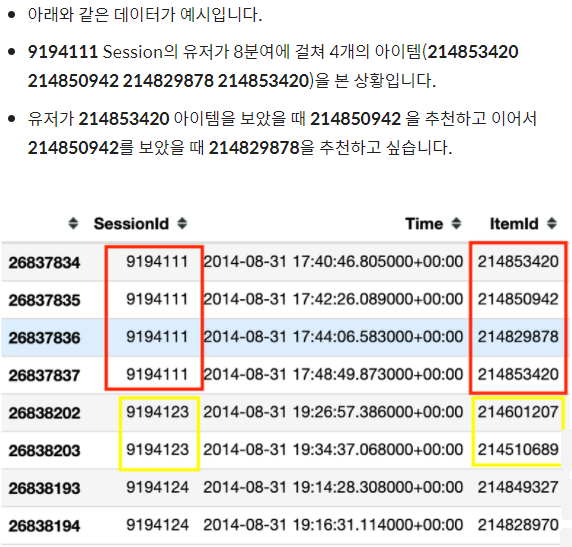
- 고객에게 그 고객과 유사한 다른 고객이 좋아하는 상품을 추천해 주는 전략은 언제나 유효할까? NO
  - 추천 전략에의 기본 전제에는 한가지 맹점 존재 
  - 고객의 선호가 고정된 것이라고 보는 것 
  - 그러나 고객의 마음은 늘 변덕스럽다 
  - 전자상거래 플랫폼에서는 '바로 지금 시점에 이 고객이 좋아할 만한 상품'을 추천해 주고 싶어 
  - 이 고객이 바로 지금 좋아할만 한 것을 알아낼 단서는 어디에??

## 실습 

### 1. 데이터 가져오기 
- 프로젝트 폴더를 만들고, 데이터 폴더에서 프로젝트 폴더로 링크를 연결
- 추천 시스템을 주로 다루는 학회 RecSys에서는 매년 추천을 주제로 대회를 개최함
- 2015년도에는 YOOCHOOSE라는 추천 엔진 솔루션 회사에서 E-Commerce 데이터를 공개했는데 실습은 이 데이터를 활용함

`$ mkdir -p ~/aiffel/yoochoose/data`<br>
`$ ln -s ~/data/* ~/aiffel/yoochoose/data`

In [1]:
# 데이터 설명(README)를 읽어 봅니다. 
import os
f = open(os.getenv('HOME')+'/aiffel/yoochoose/data/dataset-README.txt', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

﻿SUMMARY




This dataset was constructed by YOOCHOOSE GmbH to support participants in the RecSys Challenge 2015.

See  http://recsys.yoochoose.net for details about the challenge.



The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session

is encapsulating the click events that the user performed in the session.

For some of the sessions, there are also buy events; means that the session ended

with the user bought something from the web shop. The data was collected during several

months in the year of 2014, reflecting the clicks and purchases performed by the users

of an on-line retailer in Europe.  To protect end users privacy, as well as the retailer,

all numbers have been modified. Do not try to reveal the identity of the retailer.



LICENSE


This dataset is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0

International License. To view a copy of this license, visit http://creativecommons.org/licenses/by-nc-nd

#### 데이터 설명
- 주목할 점
1. 유저에 대한 정보를 전혀 알 수 없습니다. (성별, 나이, 장소, 마지막 접속 날짜, 이전 구매 내역 등등 )
2. 아이템에 대한 정보도 전혀 알 수 없습니다. (실제로 어떤 물건인지, 사진이나 설명, 가격)

- **유저에 대한 정보를 알 수 있는 경우** **Sequential Recommendation** 
  - 유저와 아이템의 추가 정보를 Sequential Recommendation 모델에 적용하는 분야는 Context-Aware 라는 키워드로 활발히 연구되고 있습니다.

- E-Commerce 데이터의 특징
1. 비로그인 상태로 탐색하는 유저가 많습니다.
2. 로그인 상태로 탐색한다고 할지라도 접속할 때 마다 탐색하는 의도가 뚜렷하게 다릅니다.
3. 마우스를 사야겠다고 마음먹고 탐색한 이력이 칫솔을 사야겠다 생각하고 탐색하는 경우에 도움이 되지 않습니다.
---

## 2. Data Preprocess

### 2.1 Data Load
- 데이터를 불러와 살펴보고 주요 통계치 확인.
- Click 데이터에 있는 Session Id, TimeStamp, ItemId 칼럼만 사용
- pathlib 라이브러리[참고URL](https://brownbears.tistory.com/415#:~:text=pathlib%20%EC%84%A4%EB%AA%85,%EB%A1%9C%20%EB%8B%A4%EB%A3%A8%EC%9E%90%EB%8A%94%20%EA%B2%83%EC%9E%85%EB%8B%88%EB%8B%A4.&amp;text=pathlib%EC%9D%80%20%EC%8A%AC%EB%9E%98%EC%8B%9C(/)%EA%B0%80,%EC%A7%81%EA%B4%80%EC%A0%81%EC%9C%BC%EB%A1%9C%20%EC%9D%B4%ED%95%B4%ED%95%A0%20%EC%88%98%20%EC%9E%88%EC%8A%B5%EB%8B%88%EB%8B%A4.)
  - 파일 시스템 경로를 문자가 아닌 객체로 다루게 함
  - 연산자 새롭게 정의 가능
  - `/` 가 경로 구분 문자로 사용하여 직관적 이해가능 

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data') 
train_path = data_path / 'yoochoose-clicks.dat'
train_path

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep=',', header=None, usecols=[0, 1, 2],
                       parse_dates=[1], dtype={0: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['SessionId', 'Time', 'ItemId']
    return data

In [ ]:
# 시간이 좀 걸릴 수 있습니다. 메모리도 10GB 가까이 소요될 수 있으니 메모리 상태에 주의해 주세요.  

data = load_data(train_path, None)
data.sort_values(['SessionId', 'Time'], inplace=True) 
# data를 id와 시간 순서로 정렬해줍니다.
data

# 33003944 rows × 3 columns 가 나옴.

In [ ]:
#추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수(세션 수)와 아이템 수
data['SessionId'].nunique(), data['ItemId'].nunique()
#(9249729, 52739)

- 세션의 숫자가 약 900만 개, 아이템 숫자는 약 5만 개
- 이 수치가 유저의 수가 900만명이라는 것은 아닙니다. 같은 유저가 여러 개의 세션을 만들수도 있기 때문

---
### 2.2 Session Length
- 각 세션이 대략 몇 개의 클릭 데이터를 갖는지 확인
  - 여기서 session_length란 같은 Session Id를 공유하는 데이터 row의 개수를 의미
  - 여기서 SessionId란 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자
  - 로그인하지 않았기 때문에 이 사용자가 누군지는 알수 없어도, 최소한 특정 사용자의 행동을 SessionId 기준으로 모아서 분류해낼 수는 있습니다. 
  - 따라서 여기서 session_length란 해당 세션의 사용자가 그 세션 동안 몇번의 액션을 취했는지(몇개의 상품정보를 클릭했는지)의 의미한다.

In [ ]:
session_length = data.groupby('SessionId').size()
session_length
# SessionId
# 1           4
# 2           6
#..
#Length: 9249729, dtype: int64

In [ ]:
# 평균값
session_length.median(), session_length.mean()
# (2.0, 3.568098481587947)

In [ ]:
# 최소값, 최대값
session_length.min(), session_length.max()
#(1, 200)

In [ ]:
# 99.9 프로의 데이터의 길이
session_length.quantile(0.999)
#41.0

- 각 세션의 길이는 보통 2~3 정도입니다.(median, mean)
  - 온라인에서 쇼핑할 때를 생각해보면 이 수치가 그럴듯하게 느껴집니다.
- 99.9% 세션은 길이가 41이하입니다.(.quantile(0.999))
- 길이가 200인 세션은 뭔가 이상합니다.(.max())

- 데이터들의 평균값을 심하게 넘는것에 대해서 알아보기

In [ ]:
# 길이가 200인것의 인덱스 0을 새로운 변수에 넣어서 확인
long_session = session_length[session_length==200].index[0]
data[data['SessionId']==long_session]

#200 rows × 3 columns
# 데이터의 타임을 보면 이상한 점이 있음 
# 동일한 날짜에 값이 많음

- 동일한 날짜에 매우 짧은 간격( 1초~1초미만)으로 지속적으로 클릭을 1시간 30분 가량 지속하고 있습니다.
- 유저들의 서비스 이용행태는 다양하기 때문에 데이터 전처리를 어떻게 할지는 **모델을 만드는 사람이 판단**
  - 예를 들어) 음악 데이터의 경우 어떤 사람은 하루종일 랜덤재생을 할 수도 있습니다. 이 유저의 데이터를 그대로 사용하는 게 좋을까요?
  - e.g.) 어떤 상품의 경우 1분 내에 20명이 10점을 주고 나갈 수도 있습니다. 이 상품을 팔기 위해 조작하고 있는 건 아닐까요?

**너무 긴 세션을 제거할 수도 있고 포함시킬 수도 있습니다. 어떻게 하면 좋을지 판단해보자**

In [ ]:
# 세션 길이에 대한 감을 더 잘 파악하기 위해 시각화
# 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

- 추천시스템은 유저-상품 관계 매트릭스를 유저 행렬과 상품 행렬의 곱으로 표현하는 Matrix Factorization 모델을 널리 사용
- User * Item Matrix의 빈칸이 너무 많아서(data sparsity) 모델이 제대로 학습되지 않을 가능성이 있다. 이 세션정보는 유저를 ID 기반으로 정리할 수 없기 때문에 세션 하나를 유저 하나로 본다면 기존의 유저-상품정보 Matrix보다 훨씬 sparse한 형태

### 2.3 Session Time
- 어떤 유저가 아이폰을 구매하려고 합니다. 2020년 5월에는 아이폰SE2를 구매하려는 사람이 많을 것입니다.
- 그러나 그로부터 몇달 후면 아이폰 12의 구매량이 엄청나게 증가하게 될 것입니다.
- 영화나 드라마 역시 마찬가지입니다. **유저들의 소비 패턴을 금방금방 변합**니다.
- 이런 이유 때문에 **추천시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요**합니다. 이번에는 **데이터가 발생한 시간**에 대해 알아봅시다.
- **추천 시스템에서 다루는 시간 관련 데이터**요소의 종류는
  - 데이터 생성 날짜 
  - 접속하는 시간대(오전, 오후, 새벽), 
  - 접속해 있는 시간, 
  - 접속하는 요일, 계절, 
  - 마지막 접속 시간, 
  - 장바구니에 넣고 지난 시간, 등등이 있음

In [ ]:
#우리가 다루려는 데이터의 시간 관련 정보를 확인
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)
# 2014-04-01 03:00:00.124000+00:00
# 2014-09-30 02:59:59.430000+00:00
# 6개월치 데이터 임을 확인

In [ ]:
type(latest)
# pandas._libs.tslibs.timestamps.Timestamp

# latest는 Timestamp 객체이
# int 객체와의 사칙연산을 지원하지 않음

- **날짜끼리의 차이**를 구하고 싶을 때는 **datetime 라이브러리의 timedelta 객체**를 사용
- 1달치 데이터만 사용할 예정

In [ ]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data
# 5641401 rows × 3 columns

### 2.4 Data Cleansing
- SessionId의 session_length가 1인 데이터도 많이 있음 확인
- 우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것
- 길이가 1인 세션은 제거
- 너무 적게 클릭된 아이템은 이상한 아이템일 가능성 있어서 제거

In [ ]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [ ]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data
# 5254242 rows × 3 columns

### 2.5 Train/ Valid/ Test split
- 모델 평가를 위해 Valid Set과 Test Set을 만들기
- 대회에서 Test Set을 제공하고 있음
  - Test 셋을 살펴보니 Training 셋과 기간이 겹칩
  - 추천 시스템은 지금 잘 예측하는 게 중요
  - 1달 전에 성능이 좋은 모델을 지금 시기에 쓰면 맞지 않을 수가 있는데, 1달전과 사용자들의 소비 패턴이 달라지기 때문
  - 이런 이유로 Session-Based Recommendation에서는 기간에 따라 Train/ Valid/ Test 셋을 나누기도 합니다.
  - 이번 자료에서는 가장 마지막 1일 기간 동안을 Test로, 2일전부터 1일전 까지를 valid set으로 나눔 
  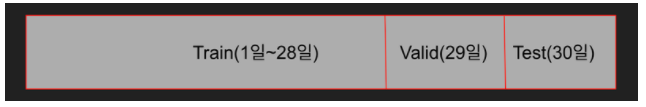

In [ ]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [ ]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [ ]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [ ]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

In [ ]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [ ]:
#데이터를 저장한 다음 data pipeline을 구축하는 단계로 넘어감
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 3.논문소개(GRU4REC)
- [SESSION-BASED RECOMMENDATIONS WITH RECURRENT NEURAL NETWORKS ](https://arxiv.org/pdf/1511.06939v4.pdf)
- Session Data에서는 처음으로 RNN 계열 모델을 적용하여 발표
- 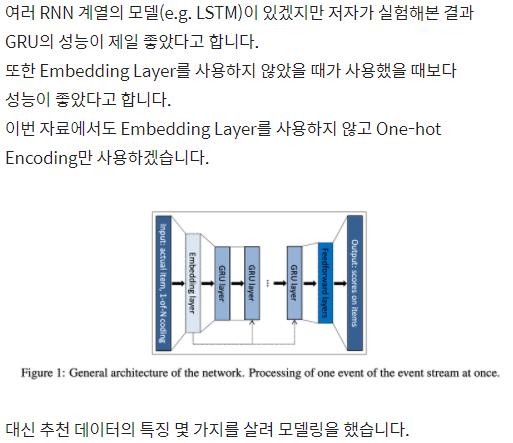
- Session-Parallel Mini-Batches :
  - 위에서 보았듯이 Session의 길이는 매우 짧은 것들이 대부분입니다. 그러나 매우 긴 것들도 있습니다.
  - 이 세션들을 데이터 샘플 하나로 보고 mini-batch를 구성하여 input으로 넣는다면 길이가 제일 긴 세션의 연산이 끝날 때까지 짧은 세션들이 기다려야 합니다.
  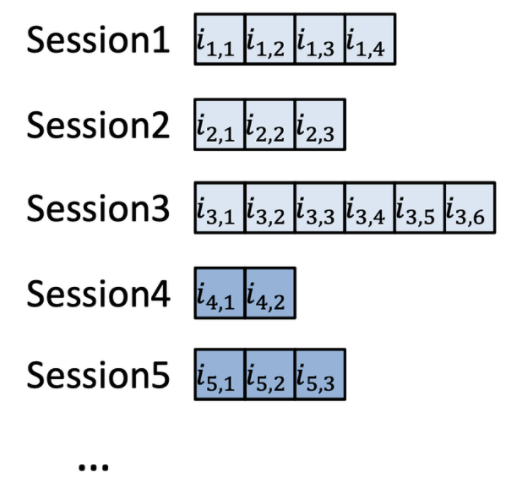
  - 위 그림에서 Session 1, 2, 3을 하나의 mini-batch로 만든다면, 이 미니배치의 연산은 Session 3의 연산이 끝나야 끝나는 식입니다.
  - 논문의 저자는 대신 Session-Parallel Mini-Batches를 제안합니다. 이름처럼 Session이 끝날 때까지 기다리지 않고 병렬적으로 계산하자는 뜻입니다.
  - 아래 그림에서 session2가 끝나면 session4가 시작하는 방식입니다.
  - 이렇게 구성했을 때 Mini-Batch의 shape은 (3, 1, 1)이 되고 RNN cell의 state가 1개로만 이루어집니다.
  - 또한 Tensorflow 기준으로 RNN을 만들 때 stateful=True 옵션을 사용하고 2처럼 세션이 끝나면 state를 0으로 만들어 줍니다.[ RNN API 보기](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN)
  
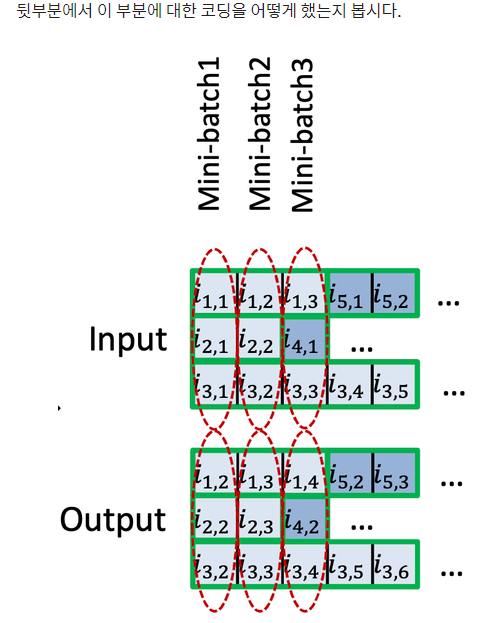
- SAMPLING ON THE OUTPUT
  - Negative Sampling와 같은 개념입니다. Item의 수가 많기 때문에 Loss를 계산할 때 모든 아이템을 비교하지 않고 인기도를 고려하여 Sampling합니다. 이번 자료에서는 구현하지 않았습니다.
- Ranking Loss
  - Session-Based Recommendation Task를 여러 아이템 중 다음 아이템이 무엇인지 Classification하는 Task로 생각할 수도 있습니다.
그러나 여러 아이템을 관련도 순으로 랭킹을 매겨서 높은 랭킹의 아이템을 추천하는 Task로도 생각할 수 있습니다.
추천 시스템 연구 분야에서는 이렇게 Ranking을 맞추는 objective function에 대한 연구가 있었고 논문의 저자 역시 이런 Loss를 사용했습니다.
그러나 이번 자료에서는 Classification Task로 보고 Cross-Entropy Loss를 사용하겠습니다.

## 4.Data Pipeline
- Session-Parallel Mini-Batch 를 구현

### 4.1 SessionDataset
- 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만들기

In [ ]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.
click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.
session_idx 변수는 각 세션을 인덱싱한 np.array

In [ ]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

In [ ]:
tr_dataset.click_offsets

In [ ]:
tr_dataset.session_idx

### 4.2 SessionDataLoader
- 파이썬 문법 iterator, generator => [코딩도장 참고](https://dojang.io/mod/page/view.php?id=2405)
- SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스
- `__iter__ `메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.
- mask는 후에 RNN Cell State를 초기화 하는데 사용할 것

In [ ]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [ ]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

In [ ]:
iter_ex = iter(tr_data_loader)

In [ ]:
# 아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만든다.
# input, output, mask 확인하자
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

## 5. Modeling

### 5.1 Evaluation Metric
- 모델 성능 평가를 위한 지표를 보겠습니다.
모델 성능에 대한 지표로 precision이나 recall이 있습니다.
Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.
이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용합니다.
추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다.
따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용합니다.
이번 자료에서는 MRR과 Recall@k를 사용하겠습니다. MRR은 정답 아이템이 나온 순번의 역수 값입니다.
따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것입
- NDCG, MRR, MAP에 대한 자세한 설명 => https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832

In [ ]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 5.2 Model Architecture
- 스텝 3에서 소개한 모델 구조를 구현하겠습니다.
- 모델 구조가 간단한 편이므로 Functional하게 모델을 만들기

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

# 모델에 사용할 hyper-parameter를 class형식으로 관리
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)


model = create_model(args)

### 5.3 Model Training
- 준비한 데이터셋과 모델을 통해 학습을 진행.
- 학습은 총 3epoch 진행되며, 대략 1시간 가량 소요될 것입니다. 
- 3epoch면 모델이 충분히 수렴하여 성능이 확인될 만큼은 아니나,
- 모델 학습이 정상적으로 진행되고 있음을 확인할 수 있는 수준은 될 것입니다.
- 배치 사이즈나 epoch 등의 설정은 위의 args에서 관리하므로 진행전 값을 확인

In [ ]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr


# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

### 5.4 Inference
- 학습이 완료 후 지금까지 학습한 모델이 테스트셋에 대해서도 유사한 수준의 성능을 내는지 검증하기

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

---
---
# 프로젝트 : Movielens 영화 SBR

##  Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작
- 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 
- SessionID 대신 UserID 항목이 들어갔다는 점입니다. 
- 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 
- 그래서 이번에는 **UserID가 SessionID 역할**을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 
- 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 
- 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

In [6]:
# 라이브러리 연결
import os
import datetime as dt
from pathlib import Path
import pandas as pd
import warnings
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [7]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  
# Time을 id와 시간 순서로 정렬해줍니다.
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## Step 1. 데이터의 전처리

- 위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행
- 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의


In [8]:
#추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수(세션 수)와 아이템 수
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

- 유저수는 6040명
- 아이템수는 3706개

In [14]:
#각 UserId가  갖는 클릭 데이터
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [15]:
# 각 사용자의 평가 갯수 평균
user_length.median(),user_length.mean()

(96.0, 165.5975165562914)

In [16]:
# 평가 갯수의 최소값 최대값
user_length.min(), user_length.max()

(20, 2314)

In [17]:
# 99.9% 의 데이터가 가지는 갯수
user_length.quantile(0.999)

1343.181000000005

- 각 사용자 별로 보통 96 ~ 165 정도..
  - median :전체 데이터 중 가운데에 있는 수 
  - mean:데이터를 모두 더한 후 데이터의 갯수로 나눈 값
  
- 사용자가 리뷰를 남기는 횟수를 의미
  - 일반적으로 96~165개의 영화 평가를 남긴다
- 99.9%의 사용자는 1343개의 평가를 남긴다..
- 최소 20개의 리뷰, 최대 2314개의 평가를 남김

- 평균을 심하게 넘어가는 데이터가 보임
- 최대값 '2314 ' 
- 최대값을 가진 데이터 확인

-세션 길이에 대한 감을 더 잘 파악하기 위해 시각화
- 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화

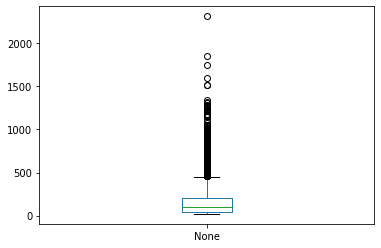

In [20]:
import matplotlib.pyplot as plt
user_length.plot.box()
plt.show()

In [18]:
long_user = user_length[user_length==2314].index[0]
data[data['UserId']==long_user]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [22]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = user_length.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

In [39]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


- 데이터의 시간 관련 정보를 확인
  - datetime.timedelta()에서 seconds인자를 활용해서 1970년 01월 01년 기준으로 언제 작성한 리뷰인지 새로운 칼럼 Datetime을 생성한다

In [30]:
from datetime import date, timedelta
# time은 경과된 초시간이기 때문에 최대값을 변경하면 
# 1970년 1월 1일 기준으로 11322일 79219초 지났음
timedelta(seconds=978300019)

datetime.timedelta(days=11322, seconds=79219)

In [31]:
data['Datetime'] = '1970-01-01 00:00:00'

In [32]:
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%Y-%m-%d %H:%M:%S")
data.dtypes

UserId               int32
ItemId               int32
Rating               int32
Time                 int64
Datetime    datetime64[ns]
dtype: object

In [33]:
data

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,1970-01-01
22,1,1270,5,978300055,1970-01-01
27,1,1721,4,978300055,1970-01-01
37,1,1022,5,978300055,1970-01-01
24,1,2340,3,978300103,1970-01-01
...,...,...,...,...,...
1000019,6040,2917,4,997454429,1970-01-01
999988,6040,1921,4,997454464,1970-01-01
1000172,6040,1784,3,997454464,1970-01-01
1000167,6040,161,3,997454486,1970-01-01


In [34]:
data.Datetime = data.Datetime + data.Time.map(lambda x : dt.timedelta(seconds=x))
data

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


In [51]:
data['Datetime'].min()

Timestamp('2000-04-25 23:05:32')

In [50]:
data['Datetime'].max()

Timestamp('2003-02-28 17:49:50')

In [49]:
data['Datetime'].max() - data['Datetime'].min()

Timedelta('1038 days 18:44:18')

In [54]:
latest = data['Datetime'].max()
latest

Timestamp('2003-02-28 17:49:50')

- 3년치의 데이터가 확인됨
- 1038일치의 데이터가 존재
- 한달치 데이터만 사용하면 1551개만 나옴
  ```python
  month_ago = latest - dt.timedelta(30)
  # 최종 날짜로부터 30일 이전 날짜를 구한다. 
  th_ data = data[data['Datetime'] > month_ago]   
  # 방금 구한 날짜 이후의 데이터만 모은다.
  th_data
```
- 따라서 3년치 데이터를 총 10만개를 이용하는 것이 좋을것같다. 
- train, valid, test 세 가지 셋트로 나누고
- 최근값부터 거꾸로 데이터를 나눠나가자
- 실습에서는 30일을 28/1/1 로 나누었다. 1038일을 기준으로 해서 test 30일 vaild 90일 나머지 918일로 설정

## Step 2. 미니 배치의 구성
-실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. 
- Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
- 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 
- Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다


### - Train/ Valid/ Test split

In [55]:
origin_data = data.copy()

In [56]:
test_days = latest - dt.timedelta(30)
test_days

Timestamp('2003-01-29 17:49:50')

In [57]:
valid_days = test_days - dt.timedelta(90)
valid_days

Timestamp('2002-10-31 17:49:50')

In [58]:
train_data = data[data['Datetime'] <= valid_days]
test_data = data[data['Datetime'] > test_days]

temp_data = data[data['Datetime'] <= test_days]
valid_data = temp_data[temp_data['Datetime'] > valid_days]

In [59]:
train_data['Datetime'].min(), train_data['Datetime'].max()

(Timestamp('2000-04-25 23:05:32'), Timestamp('2002-10-31 16:33:08'))

In [60]:
valid_data['Datetime'].min(), valid_data['Datetime'].max()

(Timestamp('2002-10-31 19:58:49'), Timestamp('2003-01-29 17:00:13'))

In [61]:
test_data['Datetime'].min(), test_data['Datetime'].max()

(Timestamp('2003-01-29 19:36:56'), Timestamp('2003-02-28 17:49:50'))

In [62]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Datetime"].min()}\n'
          f'\t Last Time : {data["Datetime"].max()}\n')

In [63]:
stats_info(train_data, 'train')
stats_info(valid_data, 'valid')
stats_info(test_data, 'test')

* train Set Stats Info
	 Events: 993688
	 Sessions: 6039
	 Items: 3705
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-10-31 16:33:08

* valid Set Stats Info
	 Events: 4970
	 Sessions: 250
	 Items: 1871
	 First Time : 2002-10-31 19:58:49
	 Last Time : 2003-01-29 17:00:13

* test Set Stats Info
	 Events: 1551
	 Sessions: 103
	 Items: 1008
	 First Time : 2003-01-29 19:36:56
	 Last Time : 2003-02-28 17:49:50



In [65]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train_data['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  
    # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train_data = indexing(train_data, id2idx)
valid_data = indexing(valid_data, id2idx)
test_data = indexing(test_data, id2idx)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [66]:
# 데이터 저장
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train_data.to_pickle(save_path / 'train.pkl')
valid_data.to_pickle(save_path / 'valid.pkl')
test_data.to_pickle(save_path / 'test.pkl')

### -Session-Parallel Mini-Batch 를 구현

In [73]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  
        # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()

        
        return offsets

In [74]:
tr_dataset = SessionDataset(train_data)
tr_dataset.df

,UserId,ItemId,Rating,Time,Datetime,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,2
37,1,1022,5,978300055,2000-12-31 22:00:55,3
24,1,2340,3,978300103,2000-12-31 22:01:43,4
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,1248
999988,6040,1921,4,997454464,2001-08-10 14:41:04,370
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,89
1000167,6040,161,3,997454486,2001-08-10 14:41:26,464


In [75]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 993224, 993347, 993688], dtype=int32)

In [77]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6036, 6037, 6038])

In [78]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = int((end - start).min() - 1)  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        print(self.dataset.session_idx)
        print(first_iters)
        print(len(first_iters))
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
#         print(np.arange(self.batch_size))
#         print((end - start) == 1)
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [81]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=256)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,Datetime,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,2
37,1,1022,5,978300055,2000-12-31 22:00:55,3
24,1,2340,3,978300103,2000-12-31 22:01:43,4
36,1,1836,5,978300172,2000-12-31 22:02:52,5
3,1,3408,4,978300275,2000-12-31 22:04:35,6
7,1,2804,5,978300719,2000-12-31 22:11:59,7
47,1,1207,4,978300719,2000-12-31 22:11:59,8
0,1,1193,5,978300760,2000-12-31 22:12:40,9


## Step 3. 모델 구성
- 실습코드 내역을 참고하여 다양하게 모델 구조를 시도



In [82]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [83]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [84]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [85]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train_data, valid_data, test_data, batch_size=50, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [86]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(50, 1, 3705)]           0         
_________________________________________________________________
GRU (GRU)                    [(50, 50), (50, 50)]      563550    
_________________________________________________________________
dropout (Dropout)            (50, 50)                  0         
_________________________________________________________________
dense (Dense)                (50, 3705)                188955    
Total params: 752,505
Trainable params: 752,505
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습
- 다양한 하이퍼파라미터를 변경해 보며 검증
- 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록

In [87]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [88]:
train_model(model, args)

Train:   0%|          | 0/19752 [00:00<?, ?it/s]

[   0    1    2 ... 6036 6037 6038]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50


Evaluation:   0%|          | 0/94 [00:00<?, ?it/s]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

Train:   0%|          | 0/19752 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.69]

	 - Recall@20 epoch 1: 0.143673
	 - MRR@20    epoch 1: 0.038761

[   0    1    2 ... 6036 6037 6038]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50


Evaluation:   0%|          | 0/94 [00:00<?, ?it/s]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

Train:   0%|          | 0/19752 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.64]

	 - Recall@20 epoch 2: 0.157959
	 - MRR@20    epoch 2: 0.046854

[   0    1    2 ... 6036 6037 6038]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50


Evaluation:   0%|          | 0/94 [00:00<?, ?it/s]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

Evaluation:  52%|█████▏    | 49/94 [00:16<00:14,  3.05it/s]

	 - Recall@20 epoch 3: 0.159184
	 - MRR@20    epoch 3: 0.050400



## Step 5. 모델 테스트
- 미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인

In [91]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test_data)

Evaluation:   0%|          | 0/28 [00:00<?, ?it/s]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50


Evaluation:  11%|█         | 3/28 [00:01<00:08,  2.92it/s]

	 - Recall@20: 0.086667
	 - MRR@20: 0.030578

